In [1]:
import torch
from torch import nn
from torch import optim
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
class DeepPolicy(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_observations, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            nn.Softmax()
        )
    
    def forward(self, x):
        return self.layers(x)

In [3]:
LEARNING_RATE = 0.0023
HIDDE_SIZE = 128

env = gym.make('CartPole-v1')
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]


In [4]:
model = DeepPolicy(n_observations, n_actions, HIDDE_SIZE)
optimizier = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Discounted Reward

In [5]:
def discount_rewards(rewards, discount_factor):
    n_rewards = len(rewards)
    timesteps = torch.arange(0, n_rewards)
    
    # calculate the discount for each time step
    discounts = torch.pow(discount_factor, timesteps)
    discounted_rewards = discounts * rewards
    
    # normalize
    discounted_rewards /= discounted_rewards.max()

    return discounted_rewards

### Loss Function

$-\gamma_t * G_t * \log \pi_s(a \mid \theta)$

$G_t$: is called the sum of all rewards until time $t$
- $G_t=r_t+r_{t+1} \ldots+r_{T-1}+r_T$

**Example**:

In [6]:
def loss_func(selected_actions, discounted_rewards):
    return -1 * torch.sum(discounted_rewards * torch.log(selected_actions))

### Training Loop

In [7]:
def select_action(model, state):
    predicted_action = model(state)

In [8]:
def generate_transitions(model, env):
    transitions = []
    state, _ = env.reset()
    # state = env.reset()
    
    while True:
        predicted_action = model(torch.from_numpy(state))
        action = torch.argmax(predicted_action, dim=-1)
        # next_state, reward, done, info = env.step(action.item())
        next_state, reward, done, truncated, info = env.step(action.item())
        
        transitions.append((
            state, action, reward, next_state
        ))
        
        if done: break
        
        state = next_state
    return transitions

In [9]:
def extract_transitions(transitions):
    states, actions, rewards = [], [], []
    
    for transition in transitions:
        state, action, reward, _ = transition
        states.append(state)
        actions.append(action)
        rewards.append(reward)
    
    return states, actions, rewards

In [22]:
N_EPISODE = 100
DISCOUNT_FACTOR = 0.99

losses = []
epsiode_len = []

for episode in range(N_EPISODE):
    transitions = generate_transitions(model=model, env=env)
    epsiode_len.append(len(transitions))

    states, actions, rewards = extract_transitions(transitions)
        
    # convert to torch tensor
    states = torch.tensor(states)
    rewards = torch.tensor(rewards)
    
    discounted_rewards = discount_rewards(rewards, discount_factor=DISCOUNT_FACTOR)
    
    # make prediction over a batch of states
    predicted_actions = model(states)
    selected_actions = predicted_actions[range(len(predicted_actions)), actions]
    
    loss = loss_func(selected_actions, discounted_rewards)
    losses.append(loss.detach().numpy())
    
    optimizier.zero_grad()
    loss.backward()
    optimizier.step()

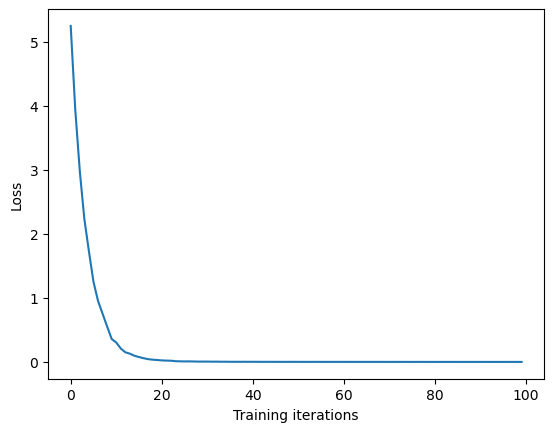

In [18]:
plt.plot(losses)
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.show()

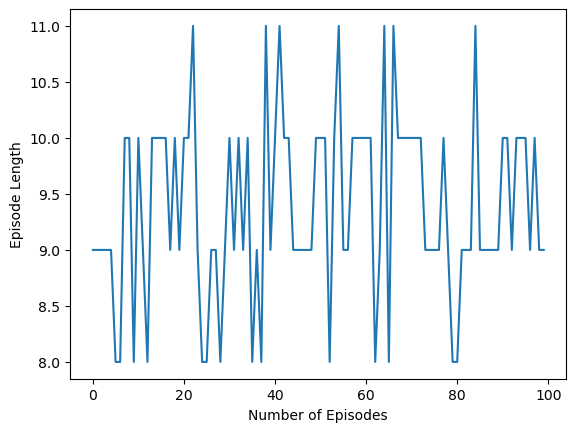

In [19]:
plt.plot(epsiode_len)
plt.xlabel('Number of Episodes')
plt.ylabel('Episode Length')
plt.show()

### Evaluate Agent

In [13]:
# from stable_baselines3.common.evaluation import evaluate_policy

# eval_env = gym.make("CartPole-v1")
# mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
# print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

In [20]:
def evaluate_agent(env, model, n_episodes):
    episode_rewards = []
    
    for episode in tqdm(range(n_episodes)):
        state, _ = env.reset()
        state = torch.from_numpy(state)
        
        total_rewards_ep = 0
        
        while True:
            predicted_action = model(state)           
            action = torch.argmax(predicted_action, dim=-1)
            
            new_state, reward, done, truncated, info = env.step(action.item())
            total_rewards_ep += reward

            if done: break
            state = torch.from_numpy(new_state)
            
        episode_rewards.append(total_rewards_ep)
    
    episode_rewards = torch.tensor(episode_rewards)
    mean_reward = torch.mean(episode_rewards)
    std_reward = torch.std(episode_rewards)
    
    return mean_reward, std_reward

In [21]:
mean_reward, std_reward = evaluate_agent(env, model, 1000)
mean_reward, std_reward

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/education/miniforge3/envs/gym/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(tensor(9.4020), tensor(0.7300))